In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Base: carpeta p06_cielo_profundo
BASE_DIR = Path.cwd().parents[0]  # estamos en .../p06_cielo_profundo/notebooks
DATA_DIR = BASE_DIR / "data"
IMG_DIR = BASE_DIR / "img"

IMG_DIR.mkdir(exist_ok=True)

csv_path = DATA_DIR / "condiciones_cielo.csv"
df = pd.read_csv(csv_path)

df.head()


,fecha,ubicacion,seeing_arcsec,sqm_mag,nubes_pct,humedad_pct,fase_lunar_pct,apto_cielo_profundo
0,2025-01-01,Santiago,1.44,18.91,85,22,96,No
1,2025-01-01,Pochoco,1.20,20.29,25,55,29,No
2,2025-01-01,Valle del Elqui,1.52,20.33,55,42,24,No
3,2025-01-01,Atacama costero,1.42,18.85,84,68,78,No
4,2025-01-02,Santiago,0.87,21.16,19,26,35,Sí


In [8]:
df.info()
df.describe(include="all")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   fecha                240 non-null    object 
 1   ubicacion            240 non-null    object 
 2   seeing_arcsec        240 non-null    float64
 3   sqm_mag              240 non-null    float64
 4   nubes_pct            240 non-null    int64  
 5   humedad_pct          240 non-null    int64  
 6   fase_lunar_pct       240 non-null    int64  
 7   apto_cielo_profundo  240 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 15.1+ KB


,fecha,ubicacion,seeing_arcsec,sqm_mag,nubes_pct,humedad_pct,fase_lunar_pct,apto_cielo_profundo
count,240,240,240.000000,240.000000,240.000000,240.000000,240.000000,240
unique,60,4,NaN,NaN,NaN,NaN,NaN,2
top,2025-01-01,Santiago,NaN,NaN,NaN,NaN,NaN,No
freq,4,60,NaN,NaN,NaN,NaN,NaN,233
mean,NaN,NaN,1.931958,19.864917,50.487500,49.800000,48.812500,NaN
std,NaN,NaN,0.675025,1.149827,28.660176,23.626841,31.396144,NaN
min,NaN,NaN,0.720000,18.010000,0.000000,10.000000,0.000000,NaN
25%,NaN,NaN,1.347500,18.727500,27.000000,28.750000,21.750000,NaN
50%,NaN,NaN,1.995000,19.920000,50.500000,50.500000,47.500000,NaN
75%,NaN,NaN,2.497500,20.875000,74.250000,69.250000,75.250000,NaN


In [9]:
import numpy as np

df2 = df.copy()

# 1) Tomamos las columnas reales del CSV y las acotamos a rangos razonables
sqm = df2["sqm_mag"].clip(18, 21.8)             # mag/arcsec² (18 = muy contaminado, 21.8 = muy oscuro)
seeing = df2["seeing_arcsec"].clip(0.7, 3.0)    # arcsec (0.7 excelente, 3.0 malo)
nubes = df2["nubes_pct"].clip(0, 100)
humedad = df2["humedad_pct"].clip(0, 100)
fase_lunar = df2["fase_lunar_pct"].clip(0, 100)

# 2) Normalizamos cada factor a [0, 1] donde 1 = mejor
# Oscuridad: más SQM = mejor
darkness_score = (sqm - 18) / (21.8 - 18)
darkness_score = darkness_score.clip(0, 1)

# Seeing: menos arcsec = mejor
seeing_score = 1 - (seeing - 0.7) / (3.0 - 0.7)
seeing_score = seeing_score.clip(0, 1)

# Nubes: menos % = mejor
cloud_score = 1 - nubes / 100.0

# Humedad: menos % = mejor
humidity_score = 1 - humedad / 100.0

# Luna: menos % = mejor
moon_score = 1 - fase_lunar / 100.0

# 3) Combinamos con pesos
score = (
    0.30 * darkness_score +
    0.25 * seeing_score +
    0.20 * cloud_score +
    0.15 * moon_score +
    0.10 * humidity_score
)

df2["score_calidad_noche"] = (score * 100).round(1).clip(0, 100)

df2.sort_values("score_calidad_noche", ascending=False).head(10)


,fecha,ubicacion,seeing_arcsec,sqm_mag,nubes_pct,humedad_pct,fase_lunar_pct,apto_cielo_profundo,score_calidad_noche
21,2025-01-06,Pochoco,0.89,21.47,27,32,10,Sí,85.2
66,2025-01-17,Valle del Elqui,0.79,20.79,9,30,10,Sí,84.7
4,2025-01-02,Santiago,0.87,21.16,19,26,35,Sí,81.4
80,2025-01-21,Santiago,0.83,21.44,20,85,28,Sí,79.0
145,2025-02-06,Pochoco,1.21,21.50,12,36,51,No,78.4
150,2025-02-07,Valle del Elqui,1.45,21.75,41,41,6,No,78.3
112,2025-01-29,Santiago,1.10,21.18,30,30,29,Sí,77.4
198,2025-02-19,Valle del Elqui,1.17,20.76,0,52,29,Sí,77.1
184,2025-02-16,Santiago,1.49,21.66,38,17,35,Sí,75.8
174,2025-02-13,Valle del Elqui,1.90,21.69,35,29,9,No,74.8


In [10]:
TOP_N = 10

top_n = (
    df2
    .sort_values("score_calidad_noche", ascending=False)
    .head(TOP_N)
    .reset_index(drop=True)
)

top_n[[
    "fecha",
    "ubicacion",
    "sqm_mag",
    "seeing_arcsec",
    "nubes_pct",
    "humedad_pct",
    "fase_lunar_pct",
    "score_calidad_noche"
]]


,fecha,ubicacion,sqm_mag,seeing_arcsec,nubes_pct,humedad_pct,fase_lunar_pct,score_calidad_noche
0,2025-01-06,Pochoco,21.47,0.89,27,32,10,85.2
1,2025-01-17,Valle del Elqui,20.79,0.79,9,30,10,84.7
2,2025-01-02,Santiago,21.16,0.87,19,26,35,81.4
3,2025-01-21,Santiago,21.44,0.83,20,85,28,79.0
4,2025-02-06,Pochoco,21.50,1.21,12,36,51,78.4
5,2025-02-07,Valle del Elqui,21.75,1.45,41,41,6,78.3
6,2025-01-29,Santiago,21.18,1.10,30,30,29,77.4
7,2025-02-19,Valle del Elqui,20.76,1.17,0,52,29,77.1
8,2025-02-16,Santiago,21.66,1.49,38,17,35,75.8
9,2025-02-13,Valle del Elqui,21.69,1.90,35,29,9,74.8


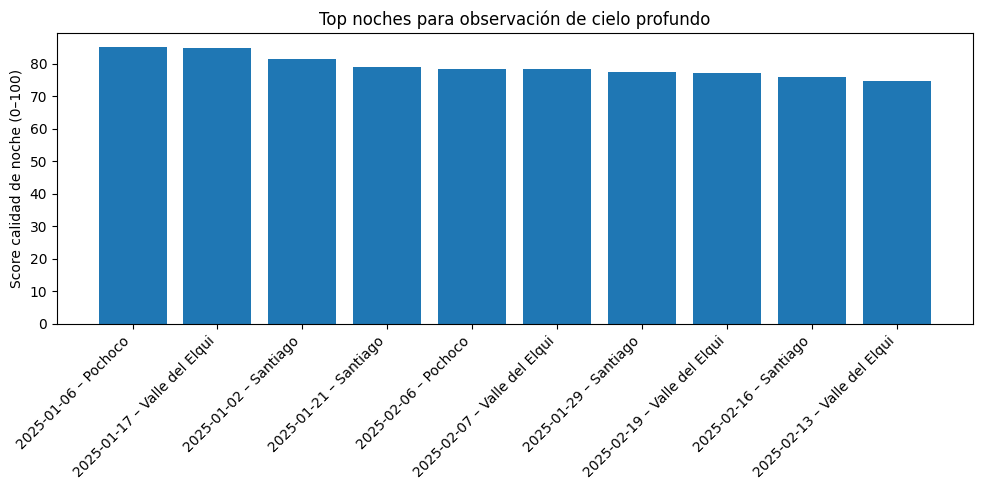

PosixPath('/Users/hugobaghetti/Desktop/PROYECTOS/Proyecto Mineria/p06_cielo_profundo/img/score_calidad_noche_top.png')

In [11]:
plt.figure(figsize=(10, 5))

labels = top_n["fecha"].astype(str) + " – " + top_n["ubicacion"]
scores = top_n["score_calidad_noche"]

plt.bar(labels, scores)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Score calidad de noche (0–100)")
plt.title("Top noches para observación de cielo profundo")

plt.tight_layout()

output_path = IMG_DIR / "score_calidad_noche_top.png"
plt.savefig(output_path, dpi=150)
plt.show()

output_path
